In [2]:
#Imports
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import Pipeline
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [3]:
#Loading the content
df = pd.read_json("https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json")

In [4]:
#loading the stemmed data with pickle
stem_data = pickle.load( open( "stemmed_data.p", "rb" )) 

In [5]:
#Mounting a DF
corpus_annot = pd.DataFrame({"preprocessed":stem_data,"target":df['target'],"target_names":df['target_names']})
corpus_annot.head()

,preprocessed,target,target_names
0,car wonder enlighten car saw dai door sport ca...,7,rec.autos
1,clock poll final final clock report acceler cl...,4,comp.sys.mac.hardware
2,question folk mac plu final gave ghost weekend...,4,comp.sys.mac.hardware
3,weitek robert kyanko rob rjck uucp wrote abrax...,1,comp.graphics
4,shuttl launch question articl cowcb world std ...,14,sci.space


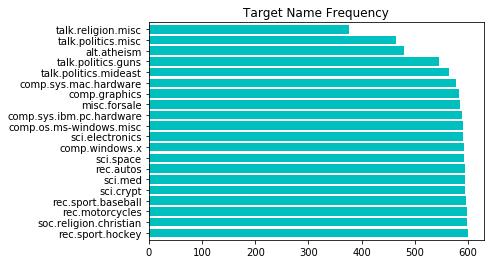

In [6]:
#Visualizing Target name frequency: they seem well distributed
df_values = df['target_names'].value_counts()
df_values.plot(kind='barh',color='c', width= 0.8)
plt.title("Target Name Frequency")
plt.rc('xtick', labelsize=8) 
plt.rc('ytick', labelsize=8) 
#How do I annotate each bar?

In [7]:
#Filtering
filtered_corpus = corpus_annot[(corpus_annot["target_names"]== 'soc.religion.christian')  
             |(corpus_annot["target_names"]=='rec.sport.hockey')
             |(corpus_annot["target_names"]=='talk.politics.mideast')
             |(corpus_annot["target_names"]=='rec.motorcycles')]

filtered_corpus.tail()

,preprocessed,target,target_names
11298,nhl team milwauke read report possibl nhl move...,10,rec.sport.hockey
11299,turkei cypru bosnia serbia greec armenia azeri...,17,talk.politics.mideast
11300,arrog christian previou articl phsd vaxc monas...,15,soc.religion.christian
11305,hezbollah apr yuma acn colost edu repli long l...,17,talk.politics.mideast
11313,stolen cbrrr stolen pasadena blue white honda ...,8,rec.motorcycles


## Part A) Test and Training Data

In [8]:
#Separating data in test and train
docs_train, docs_test, y_train, y_test = train_test_split(filtered_corpus.preprocessed, # Independent variables
                                                          filtered_corpus.target,       # Dependent variables
                                                          test_size = 0.20,             # 20% becomes test data
                                                          random_state = 12)            # Identifying the random seed for reproducibility

In [9]:
#TF-IDF Vectorizer
vec_tfidf = TfidfVectorizer(max_df=0.7, min_df=0.1, smooth_idf=False)

#Fitting TF-IDF Vectorizer to !train data!
fitted_vec = vec_tfidf.fit(docs_train)

#Transforming the data according to the trained vectorizer
transformer = fitted_vec.transform(docs_train)

#Feature names
features = vec_tfidf.get_feature_names()


tf_train = pd.DataFrame(data=transformer.toarray(),
                        index= docs_train.index,    # keeping original idices
                        columns=features)           # feature names as columns
tf_train.head()

,apr,articl,ask,awai,believ,best,better,bike,call,case,...,try,univers,us,wai,want,word,work,world,write,year
4389,0.095314,0.151092,0.0,0.0,0.0,0.0,0.588951,0.0,0.143302,0.0,...,0.0,0.0,0.0,0.328506,0.0,0.000000,0.122648,0.000000,0.066687,0.108134
10868,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.269275,0.0,0.000000,0.301601,0.000000,0.000000,0.000000
3983,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.264009,0.0,0.175334,0.000000,0.158794,0.080390,0.260711
10962,0.104566,0.082879,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.120131,0.0,0.159564,0.000000,0.000000,0.219479,0.000000
5434,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000


In [10]:
#Transforming test data according to the vector fitted to the !training data!
transformer_test = fitted_vec.transform(docs_test)

tf_test = pd.DataFrame(data=transformer_test.toarray(),
                        index= docs_test.index,        # keeping original idices
                        columns=features)              # feature names as columns
tf_test.head()

,apr,articl,ask,awai,believ,best,better,bike,call,case,...,try,univers,us,wai,want,word,work,world,write,year
9319,0.185693,0.294361,0.267365,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.259840,0.421339
7883,0.094486,0.074889,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.282467,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
6290,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.445315,0.0,0.0,0.0,0.0,0.271196,0.000000
947,0.050681,0.040170,0.145945,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.035459,0.000000
11242,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.243442,0.0,0.0,0.0,0.0,0.000000,0.000000


## Part B) Naive Bayes


*  **class sklearn.naive_bayes.MultinomialNB(*, alpha=1.0, fit_prior=True, class_prior=None)**
    - Naive Bayes classifier for multinomial models
    - The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. *However, in practice, fractional counts such as tf-idf may also work.*

In [11]:
#Naive Bayes Model
clf = MultinomialNB()
clf.fit(tf_train, y_train) #Model trained on training set

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

The prediction is derived from the test set. It is an array with the predicted targets

In [12]:
#creating the predictions
y_pred = clf.predict(tf_test)
y_pred

array([10, 15, 17, 15, 10, 15, 10, 10,  8,  8, 15, 15, 17, 15, 15, 10,  8,
       10, 10, 10, 15, 15,  8,  8, 15,  8, 17, 10, 17, 10, 15, 15, 17, 15,
        8,  8, 17,  8,  8,  8,  8, 17, 10, 15, 17, 15, 10, 17, 17, 15, 17,
       17, 10, 10, 10, 10, 17,  8, 15,  8,  8, 10, 17, 17,  8, 15, 17, 15,
       10,  8, 17, 10, 15,  8, 15, 10, 15,  8, 17, 10, 10,  8, 10, 10, 17,
        8,  8,  8, 10,  8, 10, 10, 17, 10, 17, 15, 15, 15,  8, 17, 15, 17,
       15, 15, 17,  8,  8, 15,  8, 10, 10, 15, 17, 15,  8, 10, 17,  8, 15,
       15, 17, 17,  8, 10,  8, 17,  8, 10,  8,  8,  8, 10, 15, 17,  8, 17,
       17, 17, 15,  8, 17,  8, 10, 15,  8,  8,  8,  8,  8,  8,  8, 15, 10,
       10, 17, 17, 10, 10,  8, 10,  8, 17, 10, 17, 10, 10, 15, 10,  8, 15,
       15, 15,  8,  8,  8, 10,  8, 15, 17, 15,  8, 10, 10, 17,  8,  8, 15,
       17, 17, 17,  8, 17,  8, 17, 17,  8,  8,  8, 15,  8,  8, 10, 10, 17,
        8,  8, 15, 10, 15, 10, 17,  8, 10, 15, 15, 17,  8,  8, 15,  8, 15,
       15,  8, 15,  8,  8

#### Evaluating the Model:

* **score(self, X, y[, sample_weight]):** 
    - From MultinomialNB()
    - Returns the mean accuracy on the given test data and labels
    
    
*  **sklearn.metrics.accuracy_score(y_true, y_pred, *, normalize=True, sample_weight=None)**
    - From sklearn.metrics
    - Accuracy classification score.
    - In multilabel classification, this function computes subset accuracy: the set of labels predicted for a sample must exactly match the corresponding set of labels in y_true.
    

*  **sklearn.metrics.classification_report(y_true, y_pred, *, labels=None, target_names=None, sample_weight=None, digits=2, output_dict=False, zero_division='warn')**
    - From sklearn.metrics 
    - Build a text report showing the main classification metrics

In [13]:
#Evaluating the Model: Not so much difference between training accuracy and test accuracy

print("Naïve Bayes Score: {0}".format(clf.score(tf_train ,y_train))) # on train data 

print("Accuracy: {0}".format(accuracy_score(y_test, y_pred))) # on test data

print("Classification Report: \n{0}".format(classification_report(y_test, y_pred)))

Naïve Bayes Score: 0.871822033898305
Accuracy: 0.8393234672304439
Classification Report: 
              precision    recall  f1-score   support

           8       0.82      0.87      0.84       134
          10       0.90      0.89      0.89       118
          15       0.79      0.87      0.83       106
          17       0.85      0.73      0.79       115

    accuracy                           0.84       473
   macro avg       0.84      0.84      0.84       473
weighted avg       0.84      0.84      0.84       473



## Part C) Random Forest

* **class sklearn.pipeline.Pipeline(steps, *, memory=None, verbose=False)**
     - The purpose of the pipeline is to assemble several steps that can be cross-validated together while setting different parameters. For this, it enables setting parameters of the various steps using their names and the parameter name separated by a ‘__’, as in the example below. A step’s estimator may be replaced entirely by setting the parameter with its name to another estimator, or a transformer removed by setting it to ‘passthrough’ or None.
     
     
*  **class sklearn.ensemble.RandomForestClassifier(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)**


We didn't define any parameters for the Random Forest other than the **random state**.
  
  * Controls both the randomness of the bootstrapping of the samples used when building trees (if bootstrap=True) and the sampling of the features to consider when looking for the best split at each node (if max_features < n_features)

In [14]:
rf = Pipeline([('tfidf', TfidfVectorizer(max_df=0.7, min_df=0.1)),  # Transformation step 1 Tfidf
               ('clf',RandomForestClassifier(random_state = 42)),]) # Transformation step 2 Random Forest


rf.fit(docs_train, y_train)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.7, max_features=None,
                                 min_df=0.1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None

In [15]:
#creating the predictions
y_pred_rf = rf.predict(docs_test) # not to tf_test because the pipeline already applies tf-idf
y_pred_rf

array([10, 15, 17, 15, 10, 10, 10,  8,  8,  8, 15, 15, 17, 15, 15, 10,  8,
       10, 10, 10,  8, 15,  8,  8,  8,  8, 17, 10, 17, 10,  8, 15, 17, 15,
        8,  8, 17, 10,  8, 17,  8, 17, 10, 17, 17, 15, 10, 17, 17, 15, 17,
       17, 10, 10, 10, 10, 17,  8, 15,  8,  8, 10, 17, 17,  8, 15,  8, 15,
       10,  8, 17, 10, 15,  8, 15, 10, 15,  8, 17, 10, 10, 17, 10, 10, 17,
        8,  8,  8, 17,  8, 10, 10, 17, 10, 17, 15, 15, 15,  8, 17, 15, 17,
       15, 15, 17,  8,  8,  8,  8, 10, 10, 15, 17, 15,  8, 10, 17,  8, 15,
       15, 17, 17,  8, 10,  8, 17,  8, 10,  8,  8,  8, 10, 15, 17,  8, 17,
       17, 17, 15,  8, 17,  8, 10, 15,  8, 10,  8,  8, 17,  8,  8, 15, 10,
       10, 17, 17, 10, 10, 17, 10,  8, 17, 10, 17, 10, 10, 15, 15, 17, 15,
       15, 15,  8,  8,  8, 10,  8, 15, 17, 15, 17,  8, 10, 17,  8,  8, 15,
        8, 17, 17,  8, 17,  8, 17, 17,  8,  8,  8, 15,  8,  8, 10, 10, 17,
        8,  8, 15, 10, 15, 10, 17,  8, 10, 15, 17, 17,  8,  8, 15,  8, 15,
       15,  8, 15, 17,  8

In [16]:
#Evaluating the Model: Overall higher numbers than Naïve Bayes

print("Random Forest Score: {0}".format(rf.score(docs_train ,y_train))) # on train data 

print("Accuracy: {0}".format(accuracy_score(y_test, y_pred_rf))) # on test data

print("Classification Report: \n{0}".format(classification_report(y_test, y_pred_rf)))

Random Forest Score: 0.9936440677966102
Accuracy: 0.864693446088795
Classification Report: 
              precision    recall  f1-score   support

           8       0.88      0.87      0.88       134
          10       0.85      0.88      0.87       118
          15       0.83      0.84      0.84       106
          17       0.89      0.86      0.88       115

    accuracy                           0.86       473
   macro avg       0.86      0.86      0.86       473
weighted avg       0.87      0.86      0.86       473



## Part D) Grid Search

*  **class sklearn.model_selection.GridSearchCV(estimator, param_grid, *, scoring=None, n_jobs=None, iid='deprecated', refit=True, cv=None, verbose=0, pre_dispatch='2*n_jobs', error_score=nan, return_train_score=False)**
    - Exhaustive search over specified parameter values for an estimator.
    - GridSearchCV implements a “fit” and a “score” method. It also implements “predict”, “predict_proba”, “decision_function”, “transform” and “inverse_transform” if they are implemented in the estimator used.

    - The parameters of the estimator used to apply these methods are optimized by cross-validated grid-search over a parameter grid.

In [17]:
# Parameters and values to be cross-validated
param_grid = {'min_samples_leaf': [3, 4, 5], 'n_estimators': [10, 50, 100, 200,
300, 1000]}

# Setting the model again with the same random state
rf = RandomForestClassifier(random_state = 42)

#Cross validation on the RF model
grid_search = GridSearchCV(estimator = rf,          # Model
                           param_grid = param_grid, # Dictionary of parameters previously defined
                           cv =10)                  # 10-Fold cross validation

grid_search.fit(tf_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                                 

In [18]:
# Parameters that returned the best RF performance
grid_search.best_params_

{'min_samples_leaf': 4, 'n_estimators': 300}

In [19]:
# Model using the best RF parameters
best_rf = grid_search.best_estimator_

In [20]:
#Prediction using the best RF parameters
y_pred_best_rf = best_rf.predict(tf_test)
y_pred_best_rf 

array([10, 15, 17, 15, 10, 10, 10, 10,  8,  8, 17, 15, 17, 15, 15, 10,  8,
       10, 10, 10, 10, 15,  8,  8, 10,  8, 17, 10, 17, 10,  8, 15, 17, 15,
        8,  8, 17, 10,  8, 17,  8, 17, 10, 17, 17, 15, 10, 17, 17, 15, 17,
       17, 10, 10, 10, 10, 17,  8, 15,  8,  8, 10, 17, 17,  8, 15,  8, 15,
       10,  8, 17, 10, 15,  8, 15, 10, 15,  8, 17, 10, 10, 17, 10, 10, 17,
        8,  8,  8, 17,  8, 10, 10, 17, 10, 17, 15, 15, 15, 17, 17, 15, 17,
       15, 15, 17,  8,  8, 10,  8, 10, 10, 15, 17, 15,  8, 10, 17,  8, 15,
       15, 17, 17,  8, 10,  8, 17,  8, 10,  8,  8,  8, 10, 15, 17,  8, 17,
       17, 17, 15,  8, 17,  8, 10, 15,  8, 10,  8,  8, 17,  8,  8, 15, 10,
       10, 17, 15, 10, 10, 10, 10,  8, 17, 10, 17, 10, 10, 15, 17, 17, 15,
       15, 15,  8,  8,  8, 10,  8, 15, 17, 15, 17,  8, 10, 17,  8,  8, 15,
       17, 17, 17,  8, 17,  8, 17, 17,  8,  8,  8, 15,  8,  8, 10, 10, 17,
        8,  8, 15, 10, 15, 10, 17,  8, 10, 15, 17, 17,  8,  8, 15,  8, 15,
       15,  8, 15, 17,  8

In [21]:
#Evaluating the best RF Model: 

print("Random Forest Score: {0}".format(best_rf.score(tf_train ,y_train))) # on train data 

print("Accuracy: {0}".format(accuracy_score(y_test, y_pred_best_rf))) # on test data

print("Classification Report: \n{0}".format(classification_report(y_test, y_pred_best_rf)))

Random Forest Score: 0.9528601694915254
Accuracy: 0.8752642706131079
Classification Report: 
              precision    recall  f1-score   support

           8       0.95      0.87      0.91       134
          10       0.85      0.93      0.89       118
          15       0.84      0.84      0.84       106
          17       0.86      0.86      0.86       115

    accuracy                           0.88       473
   macro avg       0.87      0.87      0.87       473
weighted avg       0.88      0.88      0.88       473



## Part E) Doc2Vec

### Train Data Representation => Define a function for that later

In [22]:
#Creation of corpus with gensim based on the !train data!
corpus_gen_train = [doc.split() for doc in docs_train]

#Inspecting the first entry
print(corpus_gen_train[0])

['hell', 'met', 'visual', 'damag', 'indic', 'articl', 'apr', 'freenet', 'carleton', 'freenet', 'carleton', 'lloyd', 'carr', 'write', 'previou', 'articl', 'maven', 'mavenri', 'altcit', 'eskimo', 'com', 'norman', 'hamer', 'sai', 'end', 'replac', 'real', 'near', 'futur', 'better', 'wear', 'total', 'nondamag', 'face', 'dot', 'rate', 'cheapi', 'fit', 'wind', 'wear', 'shoei', 'lot', 'comfort', 'keep', 'wind', 'better', 'quieter', 'minor', 'damag', 'wear', 'drop', 'paint', 'chip', 'far', 'better', 'helmet', 'poorli', 'fit', 'scratch', 'bang', 'repair', 'plu', 'confid', 'protect', 'helmet', 'continu', 'actual', 'depress', 'actual', 'crack', 'magnifi', 'glass', 'consid', 'replac', 'good', 'advic', 'coupl', 'year', 'involv', 'low', 'speed', 'getoff', 'land', 'pavement', 'head', 'helmet', 'hit', 'pavement', 'clunk', 'leav', 'coupl', 'ding', 'chip', 'paint', 'point', 'impact', 'visibl', 'damag', 'call', 'helmet', 'manufactur', 'inquir', 'damag', 'said', 'wai', 'fiberglass', 'shell', 'work', 'delam

In [23]:
from gensim.test.utils import common_texts, get_tmpfile
path = get_tmpfile("doc2vec.model")

#Tagging Documents in !train data!
documents_train = [TaggedDocument(doc, [i]) for i, doc in enumerate(corpus_gen_train)]

#Embedding the documents
model = Doc2Vec(documents_train,vector_size=100, min_count=566)  

#Saving the model
model.save("doc2vec.model")

In [24]:
#Embedding for first document
print(model.docvecs[0])

[ 1.3963367e-03 -1.1893557e-02 -4.1268421e-03  3.7784905e-03
 -2.6656841e-03  4.0297455e-04  1.7651098e-03  7.9713657e-04
 -5.2125896e-03  2.5157901e-03  1.6305648e-03  6.6535627e-03
 -4.3060565e-03  5.2296822e-03  5.2355751e-03  4.3371031e-03
 -6.5067555e-03  1.1398351e-03  1.9095560e-04 -5.9094657e-03
 -4.6825251e-03 -5.9981886e-03 -4.4597592e-03  1.9871416e-03
  5.6557120e-03 -6.0188505e-03 -6.9962889e-03  5.0287731e-03
 -5.8627115e-03 -7.6248759e-04  5.7236204e-04 -6.0463008e-03
 -2.0309682e-03  2.4674316e-03 -5.1684538e-03 -6.1786096e-03
  5.2267876e-03  6.3080224e-03 -5.8443096e-05  5.9241918e-03
 -2.6286105e-03  5.9304468e-05 -8.9045864e-04  2.0529469e-03
 -1.4413423e-03  4.0938584e-03 -2.9342831e-05  4.2279954e-03
 -1.5303650e-03  1.5876426e-03  4.4546295e-03  1.8313506e-03
 -1.1952707e-03 -3.4350883e-03 -5.4390664e-04 -7.1052648e-04
 -2.9528686e-03 -3.2611995e-03 -2.0333936e-03  6.8580406e-03
 -1.6272789e-03  2.3015083e-03  3.4936448e-03 -1.3426557e-04
  8.4517673e-03  2.28310

In [25]:
#Making a list of embeddings
doc_list = [model.docvecs[i] for i in range(len(documents_train))]

#DF of train data embeddings
embeddings_train = pd.DataFrame(data = doc_list, index = docs_train.index) #Keeping the original index
embeddings_train.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
4389,0.001396,-0.011894,-0.004127,0.003778,-0.002666,0.000403,0.001765,0.000797,-0.005213,0.002516,...,0.003752,0.002229,0.005625,0.000866,-0.000940,-0.001372,0.002383,0.002228,-0.004904,0.005052
10868,-0.007760,-0.023065,0.002202,-0.000417,-0.010338,-0.005583,-0.002406,-0.018592,-0.011225,0.000046,...,0.004696,0.008462,0.007305,0.001682,-0.002286,-0.006217,0.000839,0.009481,-0.000881,-0.007416
3983,-0.007226,-0.021738,0.001348,0.002087,-0.002993,-0.004367,0.003740,-0.012082,-0.009280,-0.002963,...,0.007613,0.003658,0.010864,-0.000443,-0.007417,-0.005375,0.005498,0.009349,-0.006156,0.001409
10962,-0.003423,-0.018520,-0.001797,0.000049,-0.001290,-0.005034,0.004260,-0.006846,-0.016246,-0.004855,...,0.006086,0.003639,0.008259,-0.004876,-0.007276,-0.000097,-0.000627,0.003411,-0.000969,-0.001017
5434,0.002350,-0.000236,-0.003939,0.003621,-0.002028,-0.002557,0.001541,-0.001977,0.001683,-0.002280,...,0.004032,-0.002015,0.000988,0.003196,-0.002971,0.003155,-0.003567,-0.003108,-0.004312,-0.000213


### Test Data Representation

In [26]:
#Creation of corpus with gensim based on the filtered df
corpus_gen_test = [doc.split() for doc in docs_test]

#Inspecting the first entry
print(corpus_gen_test[0])

['washington', 'beat', 'pitt', 'articl', 'kkq', 'acsu', 'buffalo', 'edu', 'vrw', 'ubvmsd', 'buffalo', 'edu', 'ralph', 'ambrosio', 'write', 'articl', 'apr', 'mprgate', 'mpr', 'tasallot', 'galaxi', 'mpr', 'mathew', 'tasalloti', 'write', 'penguin', 'patrick', 'win', 'cup', 'hardest', 'task', 'divis', 'sure', 'washington', 'definitli', 'throw', 'rench', 'penguin', 'plan', 'canuck', 'fan', 'think', 'chanc', 'year', 'like', 'washington', 'team', 'stop', 'penguin', 'win', 'stanlei', 'cup', 'impress', 'penguin', 'cap', 'number', 'season', 'mathew', 'tasalloti', 'mpr', 'teltech', 'vancouv', 'canada', 'cours', 'ask', 'interject', 'opinion', 'matter', 'concern', 'island', 'playoff', 'come', 'jet', 'year', 'capit', 'pen', 'number', 'game', 'playoff', 'john', 'horstmann']


In [47]:
#Making a list of embeddings of inferred vectors based on the model trained on train data
doc_list_test = [model.infer_vector(i) for i in corpus_gen_test]

#DF of test data embeddings
embeddings_test = pd.DataFrame(data = doc_list_test, index = docs_test.index) #Keeping the original index
embeddings_test.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
9319,-0.010788,-0.039692,0.002857,-0.000329,-0.006811,-0.008127,0.000173,-0.024935,-0.027606,-0.008040,...,0.016948,0.006384,0.018834,-0.006050,-0.012544,-0.007320,0.004845,0.013044,-0.002063,-0.004712
7883,-0.013020,-0.030208,-0.000214,-0.000492,-0.003337,-0.011706,0.001804,-0.016930,-0.019966,-0.010637,...,0.009585,0.005783,0.008245,-0.007979,-0.016057,-0.009085,0.001901,0.003422,-0.011730,0.001219
6290,-0.013674,-0.051941,-0.000700,-0.001908,-0.005934,-0.009560,-0.003545,-0.027874,-0.024789,-0.010275,...,0.016992,0.006905,0.016308,-0.012216,-0.011112,-0.015300,0.001851,0.008579,-0.016443,-0.000266
947,0.011609,-0.011745,-0.004681,-0.005554,0.001701,-0.010558,-0.006708,-0.017164,-0.003311,-0.014088,...,-0.000045,-0.004607,0.002184,-0.020403,0.009527,-0.012453,0.005042,-0.003774,-0.022598,-0.002325
11242,-0.004142,-0.022578,-0.003927,0.003747,-0.001252,-0.009714,-0.004644,-0.020473,-0.012297,-0.004288,...,0.010973,0.009235,0.008934,-0.007847,0.000395,-0.005111,-0.000332,0.002556,-0.009619,-0.005941


### Parameter Cross-Validation

In [32]:
# Parameters and values to be cross-validated
param_grid = {'min_samples_leaf': [3, 4, 5], 'n_estimators': [10, 50, 100, 200,
300, 1000]}

# Setting the model again with the same random state
rf = RandomForestClassifier(random_state = 42)

#Cross validation on the RF model
grid_search = GridSearchCV(estimator = rf,          # Model
                           param_grid = param_grid, # Dictionary of parameters previously defined
                           cv =10)                  # 10-Fold cross validation

grid_search.fit(embeddings_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                                 

In [34]:
# Parameters that returned the best RF performance
grid_search.best_params_

{'min_samples_leaf': 5, 'n_estimators': 1000}

In [35]:
# Model using the best RF parameters
best_rf = grid_search.best_estimator_

In [48]:
#Prediction using the best RF parameters
y_pred_best_rf = best_rf.predict(embeddings_test)
y_pred_best_rf 

array([10, 15, 17, 15, 15, 10, 10, 15, 17, 10, 15, 17, 17, 15,  8, 10, 10,
        8, 10, 15, 17, 10, 10, 10, 15, 10, 17, 15, 17, 15, 15, 10, 17, 15,
       15, 10, 17, 15, 10, 10, 10, 17, 10, 17, 17, 15, 10, 17, 17, 15, 17,
       17, 10, 10, 10, 10, 17, 10, 10, 17, 10, 10, 17, 17, 10, 15, 10, 15,
       10, 10, 15, 10,  8, 17, 15, 17, 15, 10, 17, 10, 10, 10,  8, 10, 17,
        8, 10, 10,  8, 10, 10, 10, 15, 10, 17, 15, 15, 15, 10, 17, 10, 15,
       15, 17, 10, 15, 10, 17, 10, 10, 10, 10, 17, 15, 10, 10, 17,  8, 15,
       15, 17, 17, 10, 17, 17, 17, 10, 10, 10, 17, 10, 10, 10, 17, 10, 17,
       17, 10, 15, 10, 17, 15, 10, 15, 15, 15, 10, 15, 15,  8, 15,  8, 10,
       17, 15, 17, 10, 10, 17, 10, 17, 10, 10, 17, 10, 10, 17,  8, 15, 15,
       15, 15,  8,  8, 15, 10, 15,  8,  8,  8, 10, 10, 10, 10, 10, 10, 15,
       17, 17, 17, 15, 17, 10, 17, 17, 10, 10,  8, 15, 10, 15, 10, 10, 17,
       10, 10, 15, 10, 15, 10, 17, 15, 10, 15, 10, 10, 10, 10, 15, 17, 15,
       15, 15, 15, 15, 17

In [49]:
#Evaluating the best RF Model: 

print("Random Forest Score: {0}".format(best_rf.score(embeddings_train ,y_train))) # on train data 

print("Accuracy: {0}".format(accuracy_score(y_test, y_pred_best_rf))) # on test data

print("Classification Report: \n{0}".format(classification_report(y_test, y_pred_best_rf)))

Random Forest Score: 0.9888771186440678
Accuracy: 0.5391120507399577
Classification Report: 
              precision    recall  f1-score   support

           8       0.51      0.14      0.22       134
          10       0.45      0.73      0.55       118
          15       0.61      0.69      0.65       106
          17       0.62      0.67      0.64       115

    accuracy                           0.54       473
   macro avg       0.55      0.56      0.52       473
weighted avg       0.54      0.54      0.50       473

